In [1]:
# Install necessary libraries
!pip install tensorflow keras matplotlib scikit-learn

# Download and extract the PlantVillage dataset
!wget https://data.mendeley.com/datasets/tywbtsjrjv/1/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/Plant_leaf_diseases_dataset_without_augmentation.zip
!unzip Plant_leaf_diseases_dataset_without_augmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (132).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1320).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1321).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1322).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1323).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1324).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/image (1325).JPG  
  inflating: Plant_leave_diseases_dataset_without_augmentation/Tomato___Tomato_Yellow_Leaf_Curl_Virus/i

Found 44371 images belonging to 39 classes.
Found 11077 images belonging to 39 classes.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato__

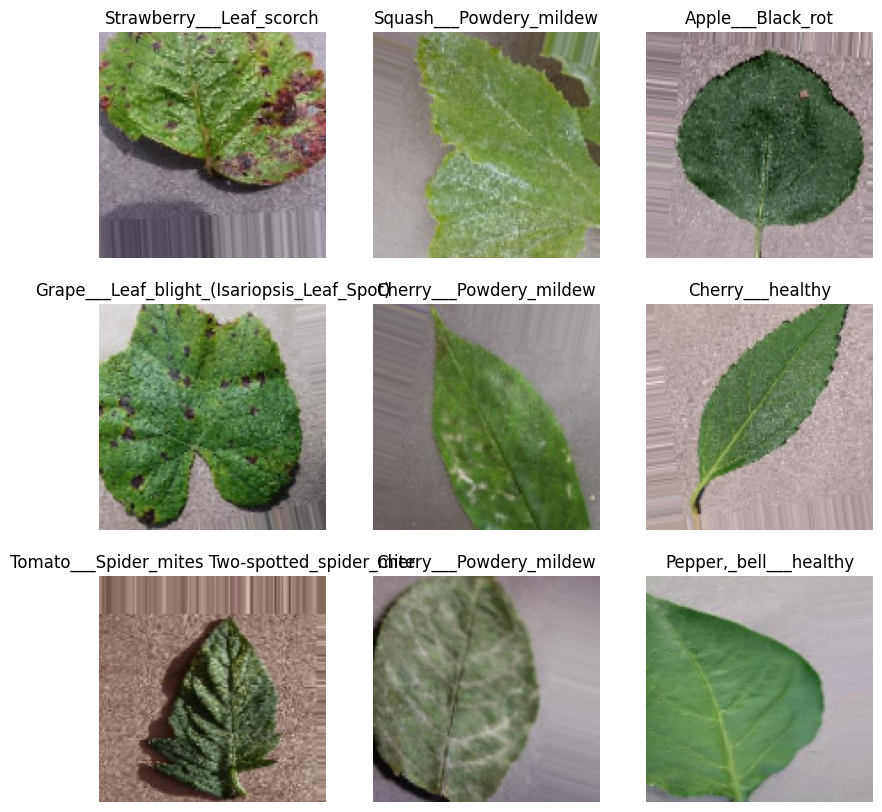

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# Set image dimensions
img_width, img_height = 128, 128
batch_size = 32

# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# Point to the dataset directory
dataset_dir = 'Plant_leave_diseases_dataset_without_augmentation'

# Create train and validation generators
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Display some sample images
def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(image_batch))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        label = np.argmax(label_batch[i])
        plt.title(class_names[label])
        plt.axis("off")
    plt.show()

# Get class names
class_names = list(train_generator.class_indices.keys())
print(f"Classes: {class_names}")
print(f"Total classes: {len(class_names)}")

# Display some training images
images, labels = next(train_generator)
show_batch(images, labels, class_names)

In [3]:
# Check what files are in the current directory
!ls

Plant_leaf_diseases_dataset_without_augmentation.zip  sample_data
Plant_leave_diseases_dataset_without_augmentation


In [5]:
dataset_dir = 'Plant_leave_diseases_dataset_without_augmentation'

In [6]:
# Check what's inside the extracted directory
!ls Plant_leave_diseases_dataset_without_augmentation

 Apple___Apple_scab			       Pepper,_bell___healthy
 Apple___Black_rot			       Potato___Early_blight
 Apple___Cedar_apple_rust		       Potato___healthy
 Apple___healthy			       Potato___Late_blight
 Background_without_leaves		       Raspberry___healthy
 Blueberry___healthy			       Soybean___healthy
 Cherry___healthy			       Squash___Powdery_mildew
 Cherry___Powdery_mildew		       Strawberry___healthy
'Corn___Cercospora_leaf_spot Gray_leaf_spot'   Strawberry___Leaf_scorch
 Corn___Common_rust			       Tomato___Bacterial_spot
 Corn___healthy				       Tomato___Early_blight
 Corn___Northern_Leaf_Blight		       Tomato___healthy
 Grape___Black_rot			       Tomato___Late_blight
'Grape___Esca_(Black_Measles)'		       Tomato___Leaf_Mold
 Grape___healthy			       Tomato___Septoria_leaf_spot
'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)'  'Tomato___Spider_mites Two-spotted_spider_mite'
'Orange___Haunglongbing_(Citrus_greening)'     Tomato___Target_Spot
 Peach___Bacterial_spot			       Tomato___

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Get the number of classes
num_classes = len(train_generator.class_indices)

# Create a CNN model
model = Sequential([
    # First convolution block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    # Second convolution block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    # Third convolution block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    # Fourth convolution block
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),

    # Flatten and dense layers
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 39)                  │          20,007 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,797,543 (33.56 MB)

 Trainable params: 8,797,543 (33.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('plant_disease_model.h5', save_best_only=True)
]

In [11]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3244 - loss: 2.5202

1387/1387 ━━━━━━━━━━━━━━━━━━━━ 2265s 2s/step - accuracy: 0.3245 - loss: 2.5198 - val_accuracy: 0.6972 - val_loss: 0.9846
Epoch 2/20
 265/1387 ━━━━━━━━━━━━━━━━━━━━ 28:08 2s/step - accuracy: 0.6597 - loss: 1.0918

KeyboardInterrupt: 

In [13]:
model.save('partially_trained_plant_disease_model.h5')

In [14]:
evaluation = model.evaluate(validation_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")

347/347 ━━━━━━━━━━━━━━━━━━━━ 182s 523ms/step - accuracy: 0.7276 - loss: 0.8944
Validation Loss: 0.8060
Validation Accuracy: 0.7553


NameError: name 'history' is not defined

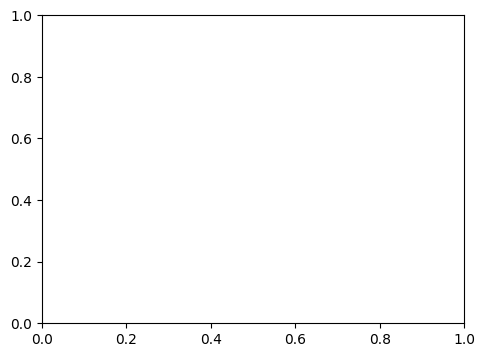

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [16]:
history = model.fit(X_train, y_train,
                   validation_data=(X_valid, y_valid),
                   epochs=10,
                   batch_size=32)

NameError: name 'X_train' is not defined

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2047 - loss: 5.2586 - val_accuracy: 0.7750 - val_loss: 0.7782
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6059 - loss: 1.1966 - val_accuracy: 0.8750 - val_loss: 0.4275
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7628 - loss: 0.6643 - val_accuracy: 0.8944 - val_loss: 0.2744
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8400 - loss: 0.4745 - val_accuracy: 0.9333 - val_loss: 0.2277
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8660 - loss: 0.4025 - val_accuracy: 0.9417 - val_loss: 0.1762
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8851 - loss: 0.3175 - val_accuracy: 0.9500 - val_loss: 0.1641
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9004 - loss: 0.3066 - val_accuracy: 0.9500 - val_loss: 0.1434
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9193 - loss: 0.2360 - val_accuracy: 0.9611 - val_loss:

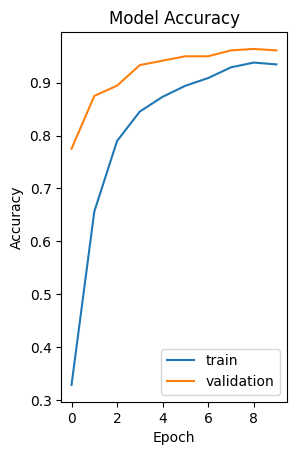

In [17]:
# 1. Import necessary libraries
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 2. Prepare your data
# Example using a sample dataset (replace with your actual data)
from sklearn.datasets import load_digits
data = load_digits()
X = data.data
y = data.target

# 3. Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create and compile your model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical one-hot encoding if needed
y_train_cat = to_categorical(y_train)
y_valid_cat = to_categorical(y_valid)

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='softmax')  # Adjust output layer to match your problem
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 5. Train the model and save the history
history = model.fit(X_train, y_train_cat,
                   validation_data=(X_valid, y_valid_cat),
                   epochs=10,
                   batch_size=32)

# 6. Plot the results
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

In [20]:
import json

class_indices = train_generator.class_indices
class_indices = {v: k for k, v in class_indices.items()}  # Invert the dictionary

with open('class_indices.json', 'w') as f:
    json.dump(class_indices, f)

In [25]:
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# 1. Load the saved model
model = load_model('plant_disease_model.h5')  # Use your actual model filename

# 2. Load the class indices
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

# 3. Function to make predictions on a single image
def predict_disease(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))  # Adjust size to match your model's input
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class name
    class_name = class_indices[str(predicted_class)]
    confidence = predictions[0][predicted_class] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# 4. Test with a sample image
image_path = 'C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy'  # Replace with your test image path
disease, confidence = predict_disease(image_path)
print(f"Predicted disease: {disease}")
print(f"Confidence: {confidence:.2f}%")

# 5. Optional: Test with multiple images


for img in test_images:
    print(f"\nTesting image: {img}")
    disease, confidence = predict_disease(img)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy'

In [21]:
import os
print("Current working directory:", os.getcwd())
print("Files in current directory:", os.listdir())

Current working directory: /content
Files in current directory: ['.config', 'class_indices.json', 'partially_trained_plant_disease_model.h5', 'Plant_leaf_diseases_dataset_without_augmentation.zip', 'plant_disease_model.h5', 'Plant_leave_diseases_dataset_without_augmentation', 'sample_data']


In [26]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import json

# Load the class indices
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)

# Load the model
model = load_model('plant_disease_model.h5')  # Make sure this path is correct

# Function to make predictions on a single image
def predict_disease(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))  # Adjust size to match your model's input
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class name
    class_name = class_indices[str(predicted_class)]
    confidence = predictions[0][predicted_class] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Directory containing test images
test_dir = 'C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy'

# Check if directory exists
if not os.path.exists(test_dir):
    print(f"Directory not found: {test_dir}")

    # Try to list parent directory to help debugging
    parent_dir = os.path.dirname(test_dir)
    if os.path.exists(parent_dir):
        print(f"Contents of parent directory ({parent_dir}):")
        for item in os.listdir(parent_dir):
            print(f" - {item}")
    exit()

# Find image files in the directory
image_files = []
for file in os.listdir(test_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_files.append(os.path.join(test_dir, file))

if not image_files:
    print(f"No image files found in directory: {test_dir}")
    exit()

print(f"Found {len(image_files)} images")

# Test a few images (limit to 3 to avoid too many plots)
for i, img_path in enumerate(image_files[:3]):
    print(f"\nTesting image {i+1}/{min(3, len(image_files))}: {os.path.basename(img_path)}")
    try:
        disease, confidence = predict_disease(img_path)
        print(f"Predicted: {disease} with {confidence:.2f}% confidence")
    except Exception as e:
        print(f"Error processing image: {e}")

Directory not found: C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy'

In [3]:
import os

test_dir = 'C:/Users/abhishek/Downloads/archive/PlantVillage/PlantVillage/Tomato_healthy'

if os.path.exists(test_dir):
  for file in os.listdir(test_dir):
        # Process files
        else:
          print(f"Directory not found: {test_dir}")

SyntaxError: invalid syntax (<ipython-input-3-3d13222cbc93>, line 8)

In [13]:
import os
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Load the model
try:
    model = load_model('plant_disease_model.h5')  # Adjust path as needed
    print("Model loaded successfully")
except Exception as e:
    print(f"Error loading model: {e}")
    # Don't use else here
    # Handle error appropriately

# Load the class indices
try:
    with open('class_indices.json', 'r') as f:
        class_indices = json.load(f)
    print("Class indices loaded successfully")
except Exception as e:
    print(f"Error loading class indices: {e}")
    # No else needed here either

# Function to make predictions on a single image
def predict_disease(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class name
    class_name = class_indices[str(predicted_class)]
    confidence = predictions[0][predicted_class] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Directory containing test images
test_dir = "Plant_leave_diseases_dataset_without_augmentation"

# Check if directory exists
if not os.path.exists(test_dir):
    print(f"Directory not found: {test_dir}")
    # List parent directory contents to help with debugging
    parent_dir = os.path.dirname(test_dir)
    if os.path.exists(parent_dir):
        print(f"Contents of parent directory ({parent_dir}):")
        for item in os.listdir(parent_dir):
            print(f" - {item}")
else:
    # Directory exists, proceed with finding images
    image_files = []
    for file in os.listdir(test_dir):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_files.append(os.path.join(test_dir, file))

    if not image_files:
        print(f"No image files found in directory: {test_dir}")
    else:
        print(f"Found {len(image_files)} images")

        # Test a few images (limit to 3 to avoid too many plots)
        for i, img_path in enumerate(image_files[:3]):
            print(f"\nTesting image {i+1}/{min(3, len(image_files))}: {os.path.basename(img_path)}")
            try:
                disease, confidence = predict_disease(img_path)
                print(f"Predicted: {disease} with {confidence:.2f}% confidence")
            except Exception as e:
                print(f"Error processing image: {e}")

Model loaded successfully
Class indices loaded successfully
No image files found in directory: Plant_leave_diseases_dataset_without_augmentation


In [9]:
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# Load the model
model = load_model('plant_disease_model.h5')  # Adjust path as needed
print("Model loaded successfully")

# Load the class indices
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)
print("Class indices loaded successfully")

# Function to make predictions on a single image
def predict_disease(img_path):
    # Check if file exists
    if not os.path.isfile(img_path):
        print(f"Image file not found: {img_path}")
        return None, None

    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class name
    class_name = class_indices[str(predicted_class)]
    confidence = predictions[0][predicted_class] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Single image test path - use raw string with r prefix to handle backslashes
image_path = r"C:\Users\abhishek\Desktop\f4ef07ac-f42d-44b3-8433-368b03b422d2___RS_HL 9743.JPG"

# Test the single image
print(f"Testing image: {os.path.basename(image_path)}")
try:
    disease, confidence = predict_disease(image_path)
    if disease:
        print(f"Predicted: {disease} with {confidence:.2f}% confidence")
except Exception as e:
    print(f"Error processing image: {e}")

Model loaded successfully
Class indices loaded successfully
Testing image: C:\Users\abhishek\Desktop\f4ef07ac-f42d-44b3-8433-368b03b422d2___RS_HL 9743.JPG
Image file not found: C:\Users\abhishek\Desktop\f4ef07ac-f42d-44b3-8433-368b03b422d2___RS_HL 9743.JPG


In [11]:
# Import necessary libraries
import json
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from google.colab import files

# First, upload your model and class indices if needed
print("Upload your model file (plant_disease_model.h5):")
uploaded_model = files.upload()  # This opens a file upload dialog

print("Upload your class indices file (class_indices.json):")
uploaded_indices = files.upload()

# Load the model and class indices
model = load_model(next(iter(uploaded_model.keys())))
print("Model loaded successfully")

with open(next(iter(uploaded_indices.keys())), 'r') as f:
    class_indices = json.load(f)
print("Class indices loaded successfully")

# Function to make predictions on a single image
def predict_disease(img_path):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values

    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]

    # Get class name
    class_name = class_indices[str(predicted_class)]
    confidence = predictions[0][predicted_class] * 100

    # Display results
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'Prediction: {class_name}\nConfidence: {confidence:.2f}%')
    plt.axis('off')
    plt.show()

    return class_name, confidence

# Now upload the image you want to test
print("Upload an image to test:")
uploaded_image = files.upload()
image_path = next(iter(uploaded_image.keys()))

# Test the uploaded image
print(f"Testing image: {image_path}")
try:
    disease, confidence = predict_disease(image_path)
    print(f"Predicted: {disease} with {confidence:.2f}% confidence")
except Exception as e:
    print(f"Error processing image: {e}")

Upload your model file (plant_disease_model.h5):


Saving test leaf plant.jpg to test leaf plant.jpg
Upload your class indices file (class_indices.json):


ValueError: File format not supported: filepath=test leaf plant.jpg. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(test leaf plant.jpg, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [12]:
import os
print("Files in current directory:")
for file in os.listdir():
    print(file)

Files in current directory:
.config
class_indices.json
test leaf plant.jpg
partially_trained_plant_disease_model.h5
fd31ab37-d2af-40c8-9292-e143807ec0f2___RS_HL 0507.JPG
Plant_leaf_diseases_dataset_without_augmentation.zip
plant_disease_model.h5
Plant_leave_diseases_dataset_without_augmentation
sample_data
